# See Through Gradients: Image Batch Recovery via GradInversion

本笔记本显示了**小批量图像梯度反转**的示例，如"See Through Gradients: Image Batch Recovery via GradInversion"中所述。

Paper URL: https://openaccess.thecvf.com/content/CVPR2021/html/Yin_See_Through_Gradients_Image_Batch_Recovery_via_GradInversion_CVPR_2021_paper.html

**这只是原始攻击的部分重新实现**，没有可用的代码。 如果您对这些超参数有更好的想法，请随时给我们留言！

# 摘要

之前的工作仅表明在非常严格的条件下恢复给定梯度的输入数据的可能性 - 单个输入点，或没有非线性的网络，或小的 32x32 px 输入批次。 因此，对较大批次的梯度进行平均被认为是安全的。 <span class="girk">在这项工作中，我们引入了 GradInversion，使用它也可以在 ImageNet（1000 个类，224x224 px）等复杂数据集上为大型网络（如 ResNets（50 层））恢复来自较大批次（8 - 48 个图像）的输入图像 。</span>

<span class="birk"><span class="girk">我们制定了一个优化任务，将随机噪声转换为自然图像，匹配梯度，同时规范图像保真度。 我们还提出了一种给定梯度的目标类标签恢复算法。 我们进一步提出了一个组一致性正则化框架，其中从不同随机种子开始的多个代理一起工作以找到原始数据批次的增强重建。</span></span> 我们表明，梯度编码的信息量惊人，因此即使对于复杂的数据集、深度网络和大批量大小，也可以通过 GradInversion 以高保真度恢复所有单个图像。

# 开始

In [1]:
# try:
#     import breaching
# except ModuleNotFoundError:
#     # 如果找不到 'breaching' 模块，可能是因为正在直接在 'examples' 目录中运行笔记本。
#     # 为了处理这种情况，将当前目录更改为父目录，然后再尝试导入 'breaching'。
#     # 如果模块已安装或笔记本位于主目录中，则可以忽略此异常。
#     import os
#     os.chdir("..")  # 将当前目录更改为父目录
#     import breaching  # 再次尝试导入 'breaching'

In [2]:
# !pip install breaching

In [3]:
import breaching  # 再次尝试导入 'breaching'

In [4]:
import torch
%load_ext autoreload
%autoreload 2

# 将日志直接重定向到 Jupyter 笔记本
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

这段代码的主要目的是在尝试导入名为 `breaching` 的模块时处理可能出现的 `ModuleNotFoundError` 异常，并在必要时改变当前工作目录。具体解释如下：

1. `try-except` 块：尝试导入 `breaching` 模块，如果模块未找到（抛出 `ModuleNotFoundError` 异常），则执行 `except` 块中的代码。

2. `except` 块：
   - 更改当前工作目录：通过 `import os; os.chdir("..")` 将当前目录更改为父目录。
   - 再次尝试导入 `breaching` 模块：通过 `import breaching` 再次尝试导入模块。

3. 导入其他模块：
   - `import torch`：导入名为 `torch` 的模块。
   - `%load_ext autoreload` 和 `%autoreload 2`：启用 Jupyter 笔记本的自动重新加载功能，以确保在执行代码之前自动重新加载模块，从而使代码中的最新更改生效。

4. 设置日志：
   - 将日志级别设置为 `INFO`。
   - 将日志处理程序配置为将日志消息直接重定向到 Jupyter 笔记本的输出。
   - 创建并配置一个名为 `logger` 的日志记录器，用于记录日志消息。

# 初始化 cfg 对象和系统设置：

这将加载完整的配置对象。 这包括“cfg.case”的用例和威胁模型的配置以及“cfg.attack”的超参数和攻击实施。 所有参数都可以在下面修改，或者用“overrides=”覆盖，就像它们是命令行参数一样。

In [5]:
# 使用 breaching 模块的 get_config 函数获取配置信息
# 可以通过 overrides 参数传递额外的配置项，这里设置了 "case=5_small_batch_imagenet" 和 "attack=seethroughgradients"
cfg = breaching.get_config(overrides=["case=5_small_batch_imagenet", "attack=seethroughgradients","+vocab_size=10000"])

# 根据当前环境决定使用 'cuda' 还是 'cpu' 作为 PyTorch 的设备
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')

# 根据配置设置 PyTorch 的一些运行参数
# 使用配置中的 benchmark 标志来设置 cudnn.benchmark
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark

# 创建一个字典 setup，包含设备和数据类型等信息，供后续使用
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

/root/miniconda3/lib/python3.8/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case small_batch_imagenet with server type honest_but_curious.


{'device': device(type='cuda'), 'dtype': torch.float32}

# 在这里修改配置选项

您可以使用“.attribute”访问权限来修改“攻击”或“案例”的任何配置：

In [6]:
# 设置数据划分策略为 "unique-class"
cfg.case.data.partition = "unique-class"

# 设置用户相关配置：用户索引为 0
cfg.case.user.user_idx = 0

# 设置每个用户的数据点数量为 1
cfg.case.user.num_data_points = 1

# 设置模型类型为 "resnet50"，其他选项包括 "resnet50ssl" 或 "resnetmoco"
cfg.case.model = "resnet50"

# 在本文中，没有公共缓冲区，但用户将批标准化统计更新与梯度更新一起发送到服务器：
# 关闭提供公共缓冲区的选项，打开提供用户缓冲区的选项
cfg.case.server.provide_public_buffers = False
cfg.case.user.provide_buffers = True

# 针对攻击的配置项（注释掉的配置项暂时不启用）
# cfg.attack.optim.langevin_noise = 1e-4
# cfg.attack.objective.scale = 1e-3

In [7]:
# 查看配置中的数据相关设置
cfg.case.data.path='/root/autodl-tmp/ImageNet/'

# 实例化所有各方

以下几行生成“服务器”、“用户”和“攻击者”对象并打印其配置的概述。

In [8]:
# 使用 breaching.cases 模块的 construct_case 函数构建用户、服务器、模型和损失函数等组件
# 根据配置 cfg.case 和运行参数 setup，得到相应的实例：user, server, model, loss_fn
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)

# 准备攻击器，使用 breaching.attacks 模块的 prepare_attack 函数
# 传入服务器的模型、损失函数、攻击配置 cfg.attack 和运行参数 setup
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

# 使用 breaching.utils 模块的 overview 函数输出用户、服务器和攻击器的概览信息
# 主要用于展示配置和组件的基本情况，方便用户了解整体架构
breaching.utils.overview(server, user, attacker)

Model architecture resnet50 loaded with 24,321,485 parameters and 53,173 buffers.
Overall this is a data ratio of     162:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet50
        model state: default
        public buffers: False

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: see-through-gradients

    Objective: Euclidean loss with scale=0.0001 and task reg=0.0
    Regularizers: Total Variation, scale=0.0001. p=1 q=1. 
                  Input L^p n

## 解释：

1. **Model architecture resnet50 loaded with 24,321,485 parameters and 53,173 buffers.**
   - 说明加载了一个名为 <span class="mark">"resnet50"</span> 的模型，该模型有 24,321,485 个参数和 53,173 个缓冲区。

2. **Overall this is a data ratio of 162:1 for target shape [1, 3, 224, 224] given that num_queries=1.**
   - 总体而言，数据比例为 162:1，针对目标形状 [1, 3, 224, 224]，考虑到 num_queries=1。

3. **User (of type UserSingleStep) with settings:**
   - 用户的类型为 "UserSingleStep"，表示用户采用单步操作。
   - 用户的设置包括：
     - 数据点数量为 1。
     - 威胁模型：
       - 用户不提供标签。
       - 用户提供缓冲区。
       - 用户提供数据点数量。
     - 数据集为 <span class="mark">"ImageNetAnimals"，</span>用户索引为 0。

4. **Server (of type HonestServer) with settings:**
   - 服务器的类型为 "HonestServer"，表示服务器是诚实但好奇的。
   - 服务器的设置包括：
     - 威胁模型为 "Honest-but-curious"，即服务器是诚实的但可能对用户的行为产生好奇。
     - 计划的查询数量为 1。
     - 没有外部/公共数据。
     - 模型：
       - 模型规范为 "resnet50"。
       - 模型状态为默认状态。
       - 没有公共缓冲区。
     - 没有任何私密信息。

5. **Attacker (of type OptimizationBasedAttacker) with settings:**
   - 攻击器的类型为 "OptimizationBasedAttacker"，表示攻击器是基于优化的。
   - 攻击器的设置包括：
     - 使用名为 "see-through-gradients" 的超参数模板。
     - 目标函数为欧几里得损失，缩放系数为 0.0001，任务正则化项为 0.0。
     - 正则化项包括总变差正则化（scale=0.0001，p=1，q=1）、输入 L^p 范数正则化（scale=1e-06，p=2）和深反演正则化（scale=0.1，first-bn-mult=10）。
     - 未定义增强操作。
     - 优化配置：
       - 优化器为 Adam。
       - 非签名（signed=False）。
       - 步长为 0.1。
       - 有界（boxed=True）。
       - 最大迭代次数为 20000。
       - 步长衰减采用余弦衰减。
       - Langevin 噪声为 0.01。
       - 热身阶段迭代次数为 50。
       - 未定义梯度剪裁。
       - 回调每 1000 次迭代。

# 模拟受攻击的 FL 协议

这种交换是联邦学习协议中单个查询的模拟。 服务器发出“server_payload”，用户根据其私有本地数据计算更新。 该用户更新是“shared_data”，并且包含例如最简单情况下模型的参数梯度。 `true_user_data` 也由 `.compute_local_updates` 返回，但当然不会转发到服务器或攻击者，仅用于（我们的）分析。

In [9]:
# 从服务器获取要分发给用户的有效负载
server_payload = server.distribute_payload()

# 用户根据服务器提供的有效负载计算本地更新
# shared_data 包含所有用户共享的数据
# true_user_data 包含用户私有的数据
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 0 in model mode: training.


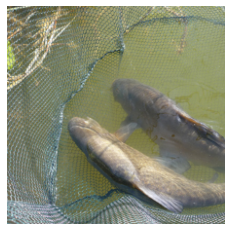

In [10]:
user.plot(true_user_data)

# 重建用户数据：

现在我们发起攻击，仅基于“server_payload”和“shared_data”重建用户数据。

您可以提前中断计算以查看部分解决方案。

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [0] through strategy yin.
| It: 1 | Rec. loss: 75.0475 |  Task loss: 13.3662 | T: 0.42s
| It: 1001 | Rec. loss: 16.6672 |  Task loss: 0.0211 | T: 140.69s
| It: 2001 | Rec. loss: 4.1224 |  Task loss: 0.0989 | T: 109.24s
| It: 3001 | Rec. loss: 3.3817 |  Task loss: 0.0095 | T: 107.97s
| It: 4001 | Rec. loss: 3.0790 |  Task loss: 0.0231 | T: 105.24s
| It: 5001 | Rec. loss: 1.6269 |  Task loss: 0.0067 | T: 108.07s
| It: 6001 | Rec. loss: 3.1677 |  Task loss: 0.0338 | T: 107.26s
| It: 7001 | Rec. loss: 13.6888 |  Task loss: 0.0233 | T: 107.61s
| It: 8001 | Rec. loss: 20.8143 |  Task loss: 0.0170 | T: 107.68s
| It: 9001 | Rec. loss: 1.6142 |  Task loss: 0.0195 | T: 108.12s
| It: 10001 | Rec. loss: 1.9683 |  Task loss: 0.0229 | T: 108.56s
| It: 11001 | Rec. loss: 2.1948 |  Task loss: 0.0256 | T: 108.33s
| It: 12001 | Rec. loss: 14.9948 |  Task loss: 0.0207 | T: 109.17s
| It: 13001 | Rec. loss: 1.2146 |  Task loss: 0.0144 | T: 108.26s
| It: 14001 | Rec. loss: 0.8420 |  Task lo

接下来，我们将评估指标，将“reconstructed_user_data”与“true_user_data”进行比较。

In [13]:
!pip install pytorch_wavelets

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 54 kB 3.3 MB/s eta 0:00:011


In [14]:
!pip install kornia

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 756 kB 3.4 MB/s eta 0:00:01


In [17]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0341 | PSNR: 14.67 | FMSE: nan | LPIPS: 0.73|
 R-PSNR: 15.71 | IIP-pixel: 100.00% | SSIM: nan | max R-PSNR: 15.71 | max SSIM: nan | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

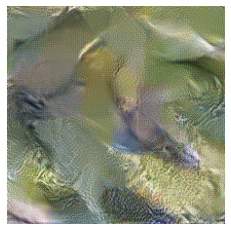

In [16]:
user.plot(reconstructed_user_data)

# 注释：

* 使用深度反演正则化的重构需要一段时间来计算。
* 深度反演正则化的可能设置是从相关的 NVIDIA 仓库¹反向工程得到的。
* 这只是透过梯度看的部分实现：分组注册部分没有包括在内（并且对我（Jonas Geiping）来说，仅从论文中也不完全清楚）。
* 在这些攻击的某些配置中，梯度重构目标实际上可以完全禁用，而且只根据批量归一化统计数据就可以同样好地恢复图像！